In [145]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [146]:
# Load a specific output folder (recommended) OR auto-pick newest
from pathlib import Path
import time

# Option A (recommended): point directly to the newest run folder
OUTPUT_DIR = Path(r"C:\Users\braid\OneDrive\Desktop\Bouncing Ball\outputs\hula_hoop_2026-02-11_10-14-04")

# Basic guardrails
if not OUTPUT_DIR.exists():
    raise FileNotFoundError(f"OUTPUT_DIR does not exist: {OUTPUT_DIR}")

q_path = OUTPUT_DIR / "q_save.npy"
u_path = OUTPUT_DIR / "u_save.npy"
X_path = OUTPUT_DIR / "X_save.npy"
for p in [q_path, u_path, X_path]:
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")

print("Using output:", OUTPUT_DIR)
print("q_save.npy mtime:", time.ctime(q_path.stat().st_mtime))
print("u_save.npy mtime:", time.ctime(u_path.stat().st_mtime))
print("X_save.npy mtime:", time.ctime(X_path.stat().st_mtime))

q = np.load(q_path)
u = np.load(u_path)
X = np.load(X_path)

params_path = OUTPUT_DIR / "params.json"
params = json.loads(params_path.read_text(encoding="utf-8")) if params_path.exists() else {}

print("q0 from file =", q[:, 0])
print("u0 from file =", u[:, 0])
if "q0" in params:
    print("params.json q0 =", params["q0"])
if "u0" in params:
    print("params.json u0 =", params["u0"])
for k in ["x0_input", "y0_input", "theta0_input", "omega0_input", "start_in_contact", "enforce_gap_distance"]:
    if k in params:
        print(f"params.json {k} =", params[k])

print("q shape:", q.shape)
print("u shape:", u.shape)
print("X shape:", X.shape)

# Show a couple later states to confirm runs differ even when q0 matches
print("q[:,1] =", q[:, 1])
print("q[:,10] =", q[:, 10])

Using output: C:\Users\braid\OneDrive\Desktop\Bouncing Ball\outputs\hula_hoop_2026-02-11_10-14-04
q_save.npy mtime: Wed Feb 11 10:14:25 2026
u_save.npy mtime: Wed Feb 11 10:14:25 2026
X_save.npy mtime: Wed Feb 11 10:14:25 2026
q0 from file = [0.                 0.18               2.0943951023931953]
u0 from file = [  0.   0. -10.]
params.json q0 = [0.0, 0.18, 2.0943951023931953]
params.json u0 = [0.0, 0.0, -10.0]
params.json x0_input = 0.0
params.json y0_input = 0.18
params.json theta0_input = 2.0943951023931953
params.json omega0_input = -10.0
q shape: (3, 1000)
u shape: (3, 1000)
X shape: (14, 1000)
q[:,1] = [-6.2369541312666104e-05  1.8011395603780106e-01  2.0317532633395481e+00]
q[:,10] = [-0.00610038719735154  0.19856413148693658  1.4679767118529885 ]


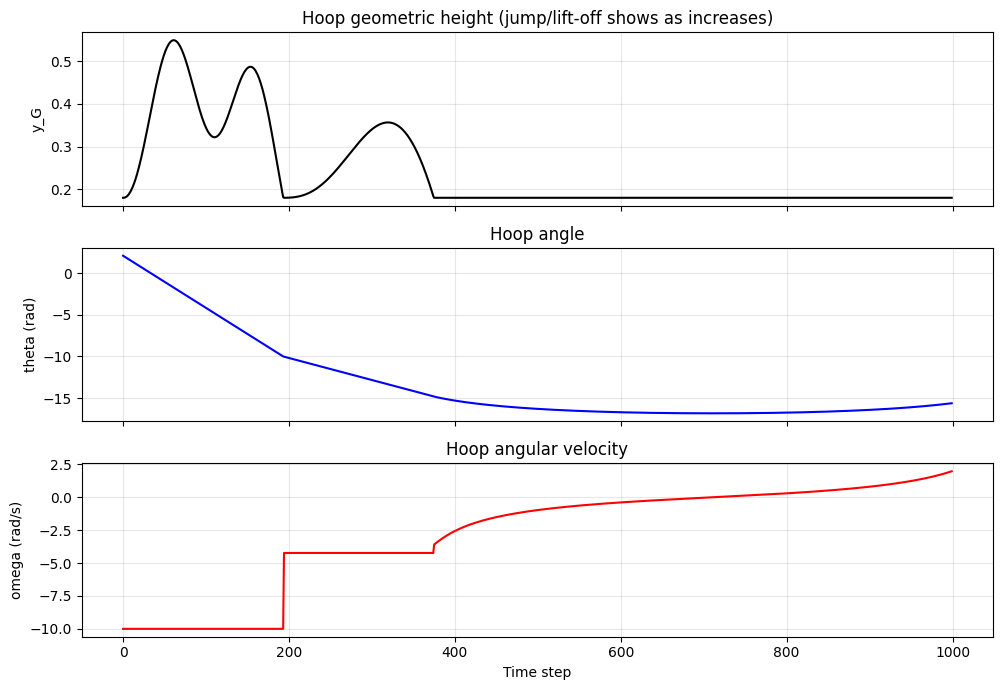

In [147]:
# Plot geometric height, angle, and angular velocity
theta = q[2, :]
omega = u[2, :]
yG = q[1, :]

fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

axes[0].plot(yG, 'k-', linewidth=1.5)
axes[0].set_ylabel('y_G')
axes[0].set_title('Hoop geometric height (jump/lift-off shows as increases)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(theta, 'b-', linewidth=1.5)
axes[1].set_ylabel('theta (rad)')
axes[1].set_title('Hoop angle')
axes[1].grid(True, alpha=0.3)

axes[2].plot(omega, 'r-', linewidth=1.5)
axes[2].set_ylabel('omega (rad/s)')
axes[2].set_xlabel('Time step')
axes[2].set_title('Hoop angular velocity')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

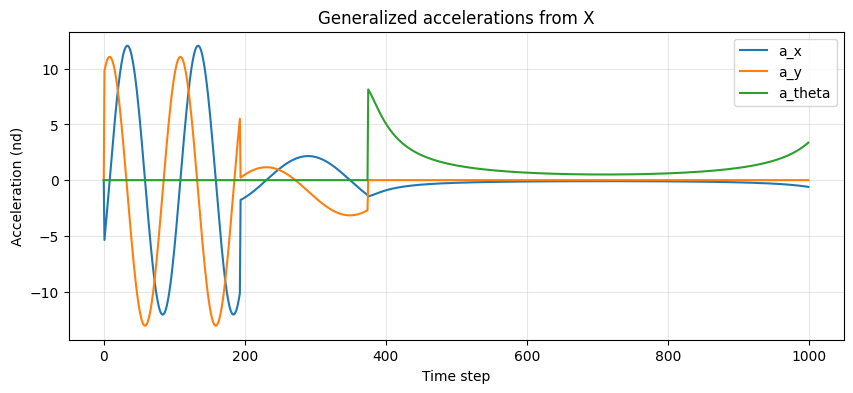

In [148]:
# Plot acceleration components from X array (a_x, a_y, a_theta) if present
if X.shape[0] >= 3:
    a_x = X[0, :]
    a_y = X[1, :]
    a_th = X[2, :]

    plt.figure(figsize=(10, 4))
    plt.plot(a_x, label='a_x')
    plt.plot(a_y, label='a_y')
    plt.plot(a_th, label='a_theta')
    plt.xlabel('Time step')
    plt.ylabel('Acceleration (nd)')
    plt.title('Generalized accelerations from X')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("X does not contain at least 3 acceleration components.")

[animation] Using output: C:\Users\braid\OneDrive\Desktop\Bouncing Ball\outputs\hula_hoop_2026-02-11_10-14-04
[animation] q[:,0] = [0.                 0.18               2.0943951023931953]
Saving animation to: C:\Users\braid\OneDrive\Desktop\Bouncing Ball\outputs\hula_hoop_2026-02-11_10-14-04\hulahoop_motion_hula_hoop_2026-02-11_10-14-04.gif
Saved.


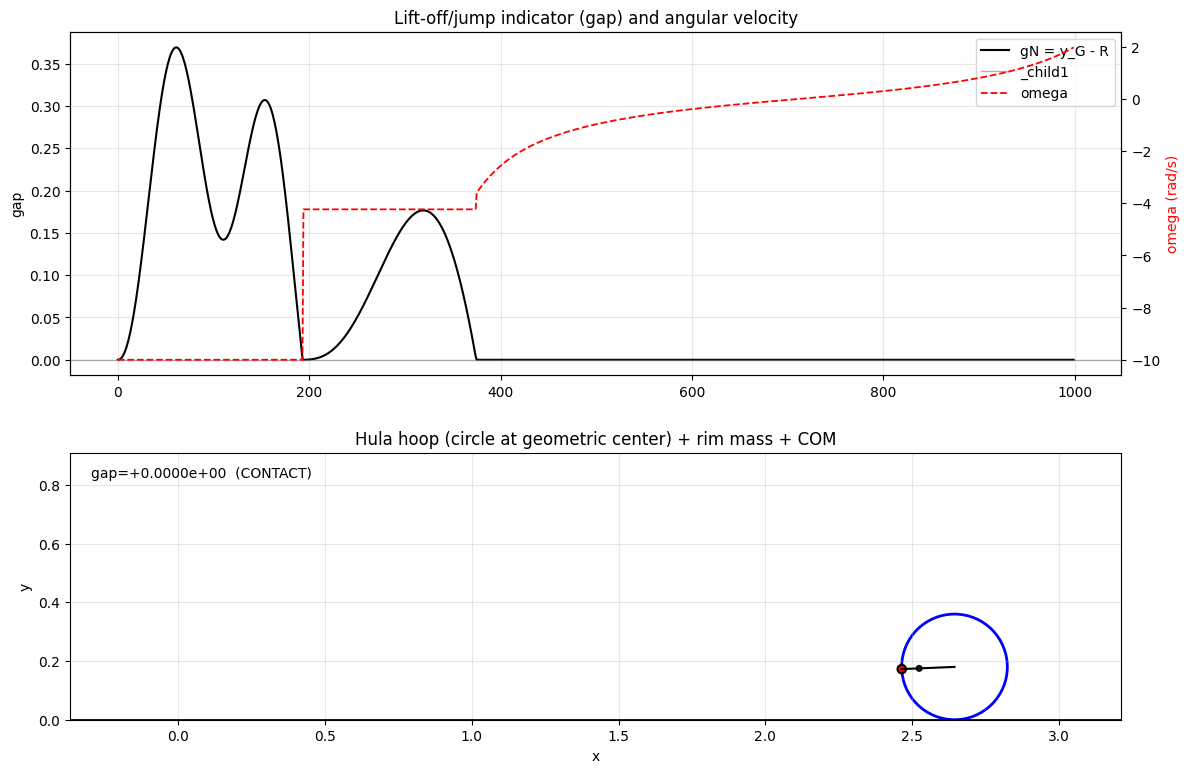

In [149]:
import matplotlib.animation as animation
from matplotlib.patches import Circle
from matplotlib.animation import PillowWriter

# Defensive reload: if you changed OUTPUT_DIR, rerunning *this* cell will still pick up the new data.
q = np.load(OUTPUT_DIR / "q_save.npy")
u = np.load(OUTPUT_DIR / "u_save.npy")
X = np.load(OUTPUT_DIR / "X_save.npy")
params_path = OUTPUT_DIR / "params.json"
params = json.loads(params_path.read_text(encoding="utf-8")) if params_path.exists() else {}
print("[animation] Using output:", OUTPUT_DIR)
print("[animation] q[:,0] =", q[:, 0])

# Parameters (prefer saved params.json)
R = float(params.get("R", 0.1))
d = float(params.get("d", 0.0))

xG = q[0, :]
yG = q[1, :]
theta = q[2, :]

# Geometric center G (circle center) from COM C
xC = xG + d * np.cos(theta)
yC = yG + d * np.sin(theta)
#yC= yG + d * np.sin(theta)
#xC= xG + d * np.cos(theta)
# Gap to ground (lift-off when > 0)
gN = yG - R

# Mass point on rim at +x_body relative to G
xM = xG + R * np.cos(theta)
yM = yG + R * np.sin(theta)

# ---- Figure layout ----
fig = plt.figure(figsize=(12, 8))

# 1) Time histories (gap and omega)
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(gN, 'k-', lw=1.5, label='gN = y_G - R')
ax1.axhline(0.0, color='gray', lw=1, alpha=0.6)
ax1.set_ylabel('gap')
ax1.grid(True, alpha=0.3)

ax1b = ax1.twinx()
ax1b.plot(u[2, :], 'r--', lw=1.3, label='omega')
ax1b.set_ylabel('omega (rad/s)', color='r')
ax1.set_title('Lift-off/jump indicator (gap) and angular velocity')

# Combined legend
lines = ax1.get_lines() + ax1b.get_lines()
labels = [ln.get_label() for ln in lines]
ax1.legend(lines, labels, loc='upper right')

# 2) Animation
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Hula hoop (circle at geometric center) + rim mass + COM')
ax2.grid(True, alpha=0.3)

# axis limits from data
xmin = float(np.min(xG) - 2 * R)
xmax = float(np.max(xG) + 2 * R)
ymin = 0.0
ymax = float(max(np.max(yG) + 2 * R, 2 * R))
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)

# Ground line
ground_line, = ax2.plot([xmin, xmax], [0, 0], 'k-', lw=2)

# Hoop circle (centered at G)
hoop_circle = Circle((xG[0], yG[0]), R, fill=False, edgecolor='blue', linewidth=2)
ax2.add_patch(hoop_circle)

# Rim mass marker
mass_patch = Circle((xM[0], yM[0]), 0.08 * R if R > 0 else 0.01, color='red', ec='black', lw=1.5)
ax2.add_patch(mass_patch)

# COM marker
com_patch = Circle((xC[0], yC[0]), 0.05 * R if R > 0 else 0.01, color='green', ec='black', lw=1.2)
ax2.add_patch(com_patch)

# Radius line from G to rim mass
radius_line, = ax2.plot([xG[0], xM[0]], [yG[0], yM[0]], 'k-', lw=1.5)

# Text showing lift-off
status_text = ax2.text(0.02, 0.95, '', transform=ax2.transAxes, va='top')

def init():
    hoop_circle.center = (xG[0], yG[0])
    mass_patch.center = (xM[0], yM[0])
    com_patch.center = (xC[0], yC[0])
    radius_line.set_data([xG[0], xM[0]], [yG[0], yM[0]])
    status_text.set_text('')
    return hoop_circle, mass_patch, com_patch, radius_line, status_text

def animate(i):
    hoop_circle.center = (xG[i], yG[i])
    mass_patch.center = (xM[i], yM[i])
    com_patch.center = (xC[i], yC[i])
    radius_line.set_data([xG[i], xM[i]], [yG[i], yM[i]])
    status_text.set_text(f"gap={gN[i]:+.4e}  ({'AIR' if gN[i] > 1e-6 else 'CONTACT'})")
    return hoop_circle, mass_patch, com_patch, radius_line, status_text

step = 5
frames = range(0, q.shape[1], step)
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=20, blit=True)

# Optional: save GIF beside the output folder (unique per folder to avoid viewer caching)
gif_path = OUTPUT_DIR / f"hulahoop_motion_{OUTPUT_DIR.name}.gif"
print("Saving animation to:", gif_path)
writer = PillowWriter(fps=30)
anim.save(gif_path.as_posix(), writer=writer)
print("Saved.")

plt.tight_layout()
plt.show()

In [150]:
np.set_printoptions(precision=17, suppress=False)
print(gN[:])
print(q[2])

[0.0000000000000000e+00 1.1395603780106622e-04 5.1646024555745962e-04
 1.3016178652137389e-03 2.4937753732406365e-03 4.1018031061644533e-03
 6.1327861318818400e-03 8.5919964569476093e-03 1.1482872345985329e-02
 1.4807004834347964e-02 1.8564131486936586e-02 2.2752137427659053e-02
 2.7367063635490102e-02 3.2403122474590706e-02 3.7852720397565709e-02
 4.3706487732800864e-02 4.9953315439033752e-02 5.6580398682980149e-02
 6.3573287069068951e-02 7.0915941324256937e-02 7.8590796215560754e-02
 8.6578829453501982e-02 9.4859636311143691e-02 1.0341150966606244e-01
 1.1221152515126592e-01 1.2123563108099195e-01 1.3045874279865766e-01
 1.3985484107687268e-01 1.4939707418349590e-01 1.5905786321338283e-01
 1.6880901027265571e-01 1.7862180909105224e-01 1.8846715762848182e-01
 1.9831567223410101e-01 2.0813780291006012e-01 2.1790394922777723e-01
 2.2758457644204833e-01 2.3715033134750091e-01 2.4657215742291100e-01
 2.5582140881170762e-01 2.6486996269156271e-01 2.7369032959226519e-01
 2.8225576122913354e

gNdot shape: (1, 1000)
gNddot shape: (1, 1000)
lambdaN shape: (1, 1000)
lambdaF shape: (1, 1000)


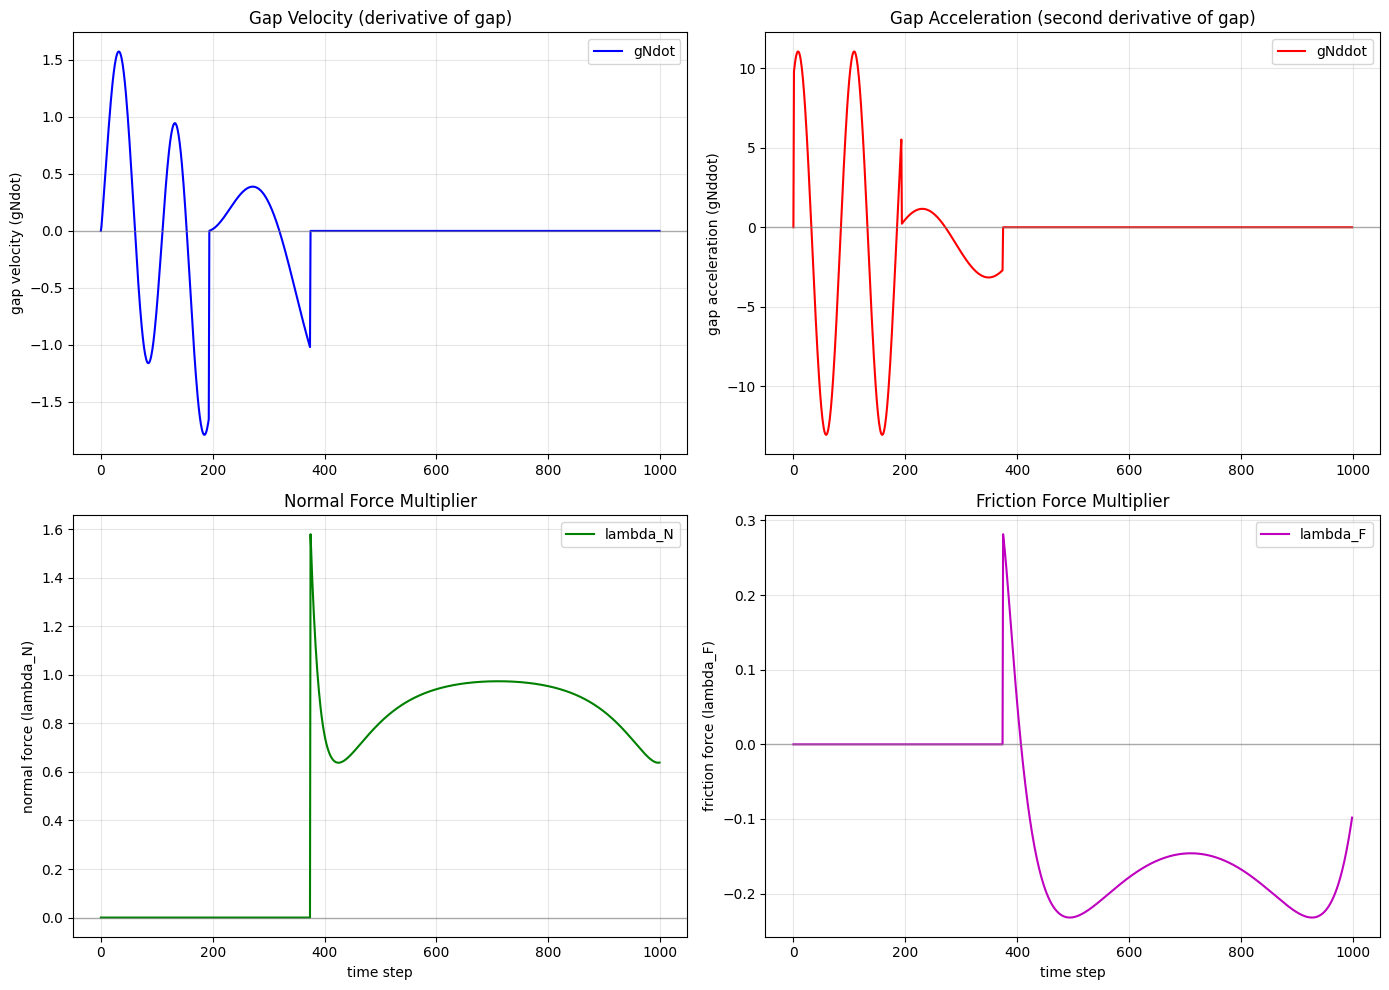

In [151]:
# Load and plot gNdot, gNddot, lambda_F, lambda_N
gNdot = np.load(OUTPUT_DIR / "gNdot_save.npy")
gNddot = np.load(OUTPUT_DIR / "gNddot_save.npy")
lambdaN = np.load(OUTPUT_DIR / "lambdaN_save.npy")

# Try loading lambdaF_save.npy first, fall back to gammaF_save.npy for older simulations
try:
    lambdaF = np.load(OUTPUT_DIR / "lambdaF_save.npy")
except FileNotFoundError:
    lambdaF = np.load(OUTPUT_DIR / "gammaF_save.npy")

print("gNdot shape:", gNdot.shape)
print("gNddot shape:", gNddot.shape)
print("lambdaN shape:", lambdaN.shape)
print("lambdaF shape:", lambdaF.shape)

# Create figure with subplots
fig_forces = plt.figure(figsize=(14, 10))

# 1) gNdot (velocity of gap)
ax1 = fig_forces.add_subplot(2, 2, 1)
ax1.plot(gNdot[0, :], 'b-', lw=1.5, label='gNdot')
ax1.axhline(0.0, color='gray', lw=1, alpha=0.6)
ax1.set_ylabel('gap velocity (gNdot)')
ax1.set_title('Gap Velocity (derivative of gap)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2) gNddot (acceleration of gap)
ax2 = fig_forces.add_subplot(2, 2, 2)
ax2.plot(gNddot[0, :], 'r-', lw=1.5, label='gNddot')
ax2.axhline(0.0, color='gray', lw=1, alpha=0.6)
ax2.set_ylabel('gap acceleration (gNddot)')
ax2.set_title('Gap Acceleration (second derivative of gap)')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3) lambda_N (normal force)
ax3 = fig_forces.add_subplot(2, 2, 3)
ax3.plot(lambdaN[0, :], 'g-', lw=1.5, label='lambda_N')
ax3.axhline(0.0, color='gray', lw=1, alpha=0.6)
ax3.set_xlabel('time step')
ax3.set_ylabel('normal force (lambda_N)')
ax3.set_title('Normal Force Multiplier')
ax3.grid(True, alpha=0.3)
ax3.legend()

# 4) lambda_F (friction force)
ax4 = fig_forces.add_subplot(2, 2, 4)
ax4.plot(lambdaF[0, :], 'm-', lw=1.5, label='lambda_F')
ax4.axhline(0.0, color='gray', lw=1, alpha=0.6)
ax4.set_xlabel('time step')
ax4.set_ylabel('friction force (lambda_F)')
ax4.set_title('Friction Force Multiplier')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()